# Лабораторная работа 2

Построив фазовую траекторию, можно (нужно) сделать оценку энтропии Колмогорова-Синая:
1. разбиения фазового пространства можно организовать с помощью алгоритма иерархической кластеризации.
2. варьируя дистанцию\размер кластеров можно получить множество (по счастью, конечное) разбиений, для которых оценить вероятности состояний и, следовательно, энтропии.
3. в качестве верхней границы (оценки KS-энтропии) системы выбрать наибольшее из рассчитанного
4. сделать выводы о связи энтропии со свойствами системы, а заодно о том, какое разбиение соответствует максимальному значению.

In [1]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.manifold import TSNE
from scipy.spatial import distance
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from scripts import *
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Определим временные ряды

In [3]:
finance_ts, _, dates = get_time_series_data()

Создадим фазовые траектории

In [4]:
embedding_dimension = 5  # Размерность вложения
time_delay = 1  # Задержка времени
epsilon = 0.1  # Порог расстояния

In [5]:
state_vectors_finance = generate_state_vectors(finance_ts, embedding_dimension, time_delay)
correlation_dimension_finance = calculate_correlation_dimension(state_vectors_finance, epsilon)

Иерархическая кластеризация

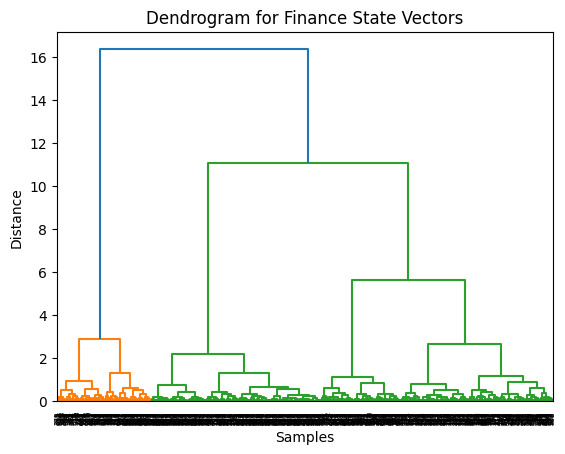

In [6]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(state_vectors_finance)
dendrogram = sch.dendrogram(sch.linkage(state_vectors_finance, method='ward'))
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Dendrogram for Finance State Vectors')
plt.show()

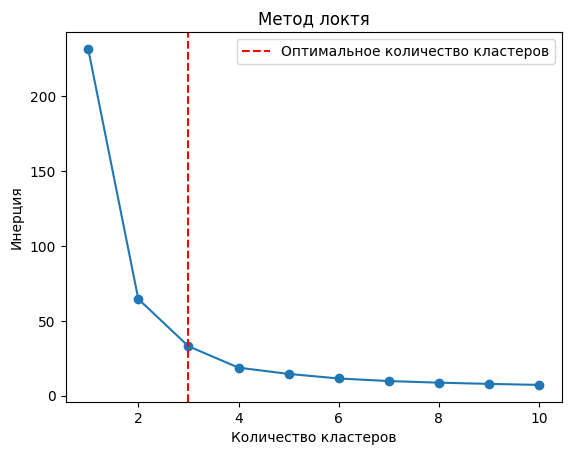

3

In [7]:
def find_optimal_clusters(phase_trajectory):
    inertia = []
    
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(phase_trajectory)
        inertia.append(kmeans.inertia_)

    plt.plot(range(1, 11), inertia, marker='o')
    plt.title('Метод локтя')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Инерция')

    kneedle = KneeLocator(range(1, 11), inertia, curve='convex', direction='decreasing')
    optimal_clusters = kneedle.elbow

    plt.axvline(x=optimal_clusters, color='r', linestyle='--', label='Оптимальное количество кластеров')
    plt.legend()

    plt.show()

    return optimal_clusters

find_optimal_clusters(state_vectors_finance)

In [8]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='ward', metric='euclidean')
clustering.fit(state_vectors_finance)

AgglomerativeClustering(metric='euclidean', n_clusters=3)

In [9]:
dims = [f'dim {i+1}' for i in range(embedding_dimension)]

df = pd.DataFrame(state_vectors_finance,columns=dims)
clustering_labels = clustering.labels_.reshape(-1, 1)

df_cluster = pd.DataFrame(clustering_labels, columns=['cluster'])
phase_traj_w_cl = pd.concat([df, df_cluster], axis=1)
print('Кластера - ',phase_traj_w_cl.cluster.unique())
phase_traj_w_cl.head(1)

Кластера -  [0 1 2]


,dim 1,dim 2,dim 3,dim 4,dim 5,cluster
0,0.457127,0.47734,0.502397,0.556626,0.627594,0


Снизим размерность через t-SNE

In [10]:
tsne = TSNE(n_components=3, perplexity=15)
tsne_result = tsne.fit_transform(phase_traj_w_cl[dims])

phase_traj_w_cl['tsne dim 1'] = tsne_result[:, 0]
phase_traj_w_cl['tsne dim 2'] = tsne_result[:, 1]
phase_traj_w_cl['tsne dim 3'] = tsne_result[:, 2]

In [11]:
import plotly.express as px

fig = px.scatter_3d(phase_traj_w_cl, x='tsne dim 1', y='tsne dim 2', z='tsne dim 3', color='cluster')

fig.update_layout(
    scene=dict(
        xaxis_title='t-SNE Dim 1',
        yaxis_title='t-SNE Dim 2',
        zaxis_title='t-SNE Dim 3'
    )
)
fig.update_traces(marker=dict(size=3))
fig.show()

In [12]:
reconstruct_data = [phase_traj_w_cl[i].values for i in dims][0]

# new_cl = np.array([phase_traj_w_cl.cluster.values for i in dims])

new_cl = np.concatenate([phase_traj_w_cl.cluster.values])

In [13]:
df = pd.DataFrame(np.array([reconstruct_data, new_cl]).T, columns=['data', 'cl'])

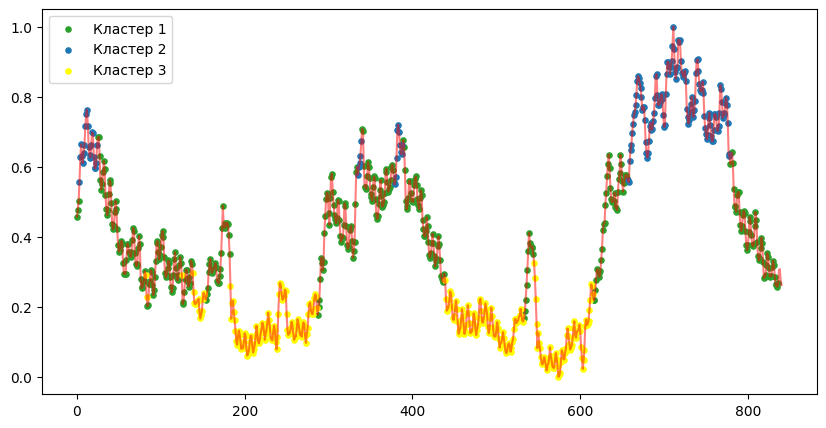

In [14]:
plt.figure(figsize=(10,5))
plt.plot(finance_ts, alpha=0.5, color='red')
col_array = ['tab:green', 'tab:blue', 'yellow']

for i in range(3):
    pass
    plt.scatter(df[df['cl'] == i]['data'].index, df[df['cl'] == i]['data'], c=col_array[i], s=14, label=f'Кластер {i+1}')
plt.xlabel('')
plt.legend()
plt.show()
plt.style.use('ggplot')

In [15]:
from scipy.stats import ks_2samp

def KSEntr(prob_distribution):
    uniform_distribution = np.full_like(prob_distribution, 1 / len(prob_distribution))


    ks_statistic, _ = ks_2samp(prob_distribution, uniform_distribution)

    ksentropy = -np.log(ks_statistic)

    return ksentropy

In [16]:
import numpy as np
prob = []
for i in range(3):
    temp, _ = np.histogram(df[df['cl'] == i]['data'], density=True, bins=len(df[df['cl'] == i])//2)
    prob.append(KSEntr(temp))

In [17]:
max(prob)

0.29940553614784016

In [18]:
KSEntr(finance_ts)

0.0011897681355887957